In [1]:
import pandas as pd
import numpy as np
from get_gene_info import get_genome_info, get_genes_from_ranges
from analyze_proteome import match_proteomic_data, calculate_proteomic_load, plot_perc_load

# Get deleted genes

Getting the genes that should be affected by the deleted ranges (Only for Delta 16 from MG1655 and all the W3110 strains as the others already report which genes are deleted)


#### MG1655

In [2]:

delta16 = pd.read_csv('../files/deleted_ranges/delta_16.csv',encoding='latin1')

genomeMG1655_path = '../files/genomes/MG1655.gb'
genomeMG1655 = get_genome_info(genomeMG1655_path)

delta_16_genes = get_genes_from_ranges(delta16, genomeMG1655)
delta_16_genes = delta_16_genes.drop_duplicates()
delta_16_genes.to_csv('../files/deleted_genes/mapped_del_genes_Δ16.csv',header=True)

1170


In [3]:
## Get files with the lengths of the genes from de MG1655

In [4]:
## Las MDS y MS56 ya traían sus bnumber, no hubo necesidad de mapear
#MS56
genes_MS56 = list(pd.read_csv('../files/deleted_ranges/MS56.csv')['Locus_Tag'])

#MDS
MDS_line = pd.read_csv('../files/deleted_ranges/MDS42_69.csv')
MD12v2 = pd.read_csv('../files/deleted_ranges/MDS12_V2.csv')
MDS_line= MDS_line.set_index('bnumber')
genes_12_v2=list(set(MD12v2['MDS12']))
genes_42 = list(set(MDS_line['MDS42_deleted'][MDS_line['MDS42_deleted']!=0].index))
genes_69 = list(set(MDS_line['MDS69_deleted'][MDS_line['MDS69_deleted']!=0].index))

In [5]:
strains_wbnumber = {'MS56':genes_MS56,'MDS12':genes_12_v2, 'MDS42':genes_42, 'MDS69':genes_69}

In [6]:
genes_finales = {}

for strain in strains_wbnumber.keys():
    genes_finales[strain] = genomeMG1655.loc[genomeMG1655.Bnumber.isin(strains_wbnumber[strain]),['Bnumber', 'Gen', 'Length']]
    genes_finales[strain] = genes_finales[strain].drop_duplicates()
    genes_finales[strain].to_csv('../files/deleted_genes/mapped_del_genes_'+strain+'.csv',header=True)

#### W3110

In [7]:
names_W3110 = ['DGF298', 'DGF327', 'MGF02', 'MGF01' ]

rangos = pd.read_csv('../files/deleted_ranges/MGF_line.csv',encoding='latin1')
genomeW3110_path = '../files/genomes/W3110.gb'
genomeW3110 = get_genome_info(genomeW3110_path)

strains = []

In [8]:
for name_W3110 in names_W3110:
    strains.append(rangos.loc[:,[name_W3110+'_L', name_W3110+'_R']].dropna())

In [9]:
genes_finales = {}

for strain in strains:
    nombre = strain.columns[0].split('_')[0]
    genes_finales[nombre] = get_genes_from_ranges(strain, genomeW3110)
    genes_finales[nombre] = genes_finales[nombre].drop_duplicates()
    genes_finales[nombre].to_csv('../files/deleted_genes/mapped_del_genes_'+nombre+'.csv',header=True)    

1727
1392
1176
1035


# Proteome mappiing

In [10]:
proteomic_data = pd.read_excel("../files/proteome_Schmidt/Proteomic_data_fg.xlsx") #Datos en fg  de distintas condiciones
proteome_size = pd.read_excel("../files/proteome_Schmidt/Proteome_size.xlsx")

In [11]:
#Delta16
delta16 = pd.read_csv("../files/deleted_genes/mapped_del_genes_Δ16.csv")
delta16 = delta16.drop('Unnamed: 0', axis=1)

In [12]:
# MG1655
names_MG1655 = ['Δ16', 'MS56', 'MDS69','MDS42','MDS12']
cepas_MG1655 = {}

for name_MG1655 in names_MG1655:
    strain_df = pd.read_csv("../files/deleted_genes/mapped_del_genes_"+name_MG1655+".csv")
    strain_df = strain_df.drop('Unnamed: 0', axis=1)
    cepas_MG1655[name_MG1655]=strain_df

In [13]:
## W3110
cepas_W3110 = {}

for name_W3110 in names_W3110:
    strain_df = pd.read_csv("../files/deleted_genes/mapped_del_genes_"+name_W3110+".csv")
    strain_df = strain_df.drop('Unnamed: 0', axis=1)
    cepas_W3110[name_W3110]=strain_df

In [14]:
matched_genes_cepas_MG1655 = match_proteomic_data(names_MG1655, cepas_MG1655, proteomic_data)
matched_genes_cepas_W3110 = match_proteomic_data(names_W3110, cepas_W3110, proteomic_data)

Δ16
MS56
MDS69
MDS42
MDS12
DGF298
DGF327
MGF02
MGF01


In [15]:
prot_load_MG1655, prot_perc_MG1655 = calculate_proteomic_load(names_MG1655, matched_genes_cepas_MG1655, proteome_size  )
prot_load_W3110, prot_perc_W3110 = calculate_proteomic_load(names_W3110, matched_genes_cepas_W3110, proteome_size  )

In [16]:
prot_load = prot_load_MG1655+prot_load_W3110

In [17]:
prot_perc = prot_perc_MG1655+prot_perc_W3110

In [18]:
new_order = ["LB","Glicerol + AA","42°C glucosa","Fructosa","pH6 glucosa",
             "Glucosa","Estrés-osmótico glucosa","Xilosa","Quimiostato µ=0.5",
             "Manosa","Glicerol","Glucosamina","Succinato","Fumarato","Piruvato",
             "Quimiostato µ=0.35","Acetato","Galactosa","Quimiostato µ=0.20",
             "Quimiostato µ=0.12","Fase estacionaria 1 día","Fase estacionaria 3 días"]

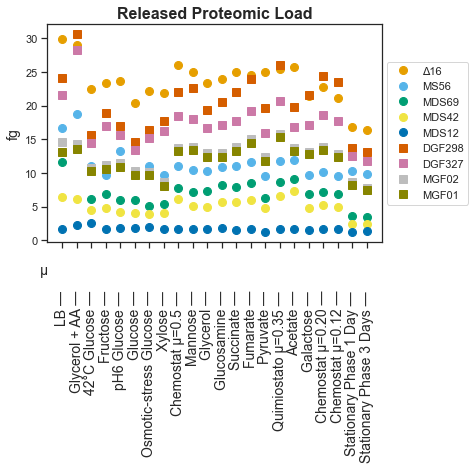

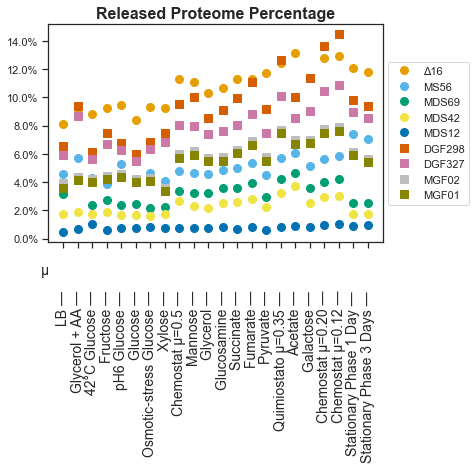

In [19]:
plot_perc_load(prot_load, prot_perc, conditions = new_order, save=True, identifier='K12' )

Solo las del artículo

In [20]:
['Δ16', 'MS56', 'MDS69','MDS42','MDS12']

['Δ16', 'MS56', 'MDS69', 'MDS42', 'MDS12']

In [21]:
representative_conditions = ["LB","Fructosa", "Glucosa","Estrés-osmótico glucosa",
                             "Quimiostato µ=0.5", "Glicerol","Fumarato","Piruvato",
                             "Acetato","Galactosa", "Quimiostato µ=0.12","Fase estacionaria 1 día"]
representative_strains = ['Δ16', 'MS56', 'MDS69', 'DGF298', 'MGF02']

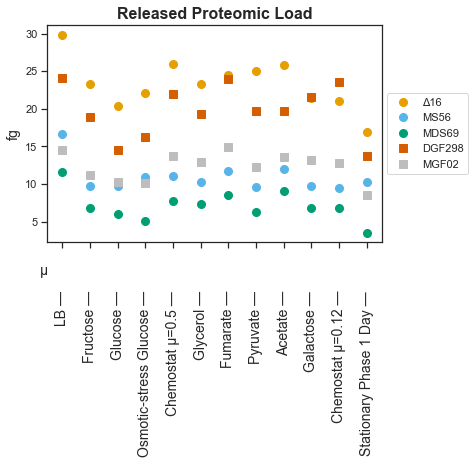

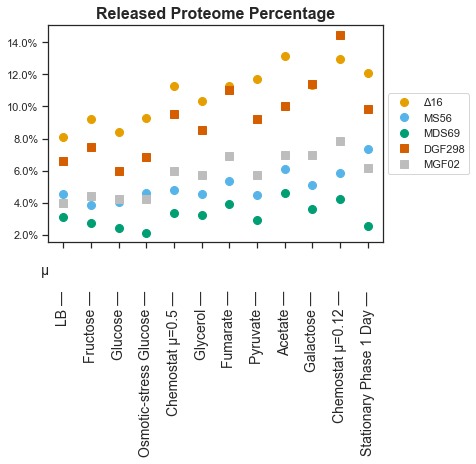

In [22]:
plot_perc_load(prot_load, prot_perc, conditions = representative_conditions,
               strains = representative_strains, save=True, identifier='K12' )